# 이웃집 토토치 파이토치 : Day 3
---

<div class="alert alert-info">
    <p>📢 해당 게시물은 <a href="https://tutorials.pytorch.kr/beginner/basics/intro.html">파이토치 기본 익히기</a>와 torchvision에서 제공하는 <a href="https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py">vgg 모델</a>을 재구성하여 작성되었습니다.</p>
</div>

## VGG16 작성 및 학습

![](https://miro.medium.com/max/700/1*gU5m4XO2awEM6Zp4DkirFA.png)

오늘은 VGG16 모델을 CIFAR-10 데이터를 학습 시켜볼 수 있는 이미지 분류기로 정의하고 이를 학습시켜 보고자 합니다.

작성해야하는 분류기와 학습 환경에 대한 조건은 다음과 같습니다.

- transforms : 정규화만을 진행한다.
- 모델 구조
    - feature [64, 64, M, 128, 128, M, 256, 256, 256, M, 512, 512, 512, M, 512, 512, 512, M] + classifier [AA, 4096, 4096, 1000]
    - feature
        - n(숫자) : filter의 수가 n개인 2d Conv Layer, `kernel_size=3`, `padding=1`
        - M : Max Pooling Layer, `kernel_size=2`, `padding=2`
        - Conv Layer 이후의 activation func는 ReLU를 사용한다.
    - classifier
        - AA : Adaptive Average Pooling(7x7)
        - n(숫자) : Linear(n unit)
- loss 함수 : CrossEntropyLoss
- optimizer = SGD, lr = 0.005, momentum=0.9
    - StepLR를 사용하여 5 step 마다 lr를 0.9배씩 줄이며 학습시킨다.
- 학습 과정에서 train set과 test set에 대한 loss와 accuracy를 출력하고, 학습 종료 후 matrix의 변화를 plot으로 출력한다.
- 학습이 완료된 모델을 `my_vgg16`이라는 이름으로 [저장](https://tutorials.pytorch.kr/beginner/basics/saveloadrun_tutorial.html)한다.

In [1]:
!pip install torchinfo

In [36]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

In [37]:
# parameters
lr = 0.001
epochs = 15
batch_size = 128

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_loader = DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transform, download=True),
    batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transform),
    batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [39]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

feature [64, 64, M, 128, 128, M, 256, 256, 256, M, 512, 512, 512, M, 512, 512, 512, M] + classifier [AA, 4096, 4096, 1000]<br>
feature<br>
n(숫자) : filter의 수가 n개인 2d Conv Layer, kernel_size=3, padding=1<br>
M : Max Pooling Layer, kernel_size=2, padding=2
Conv Layer 이후의 activation func는 ReLU를 사용한다.
classifier<br>
AA : Adaptive Average Pooling(7x7)<br>
n(숫자) : Linear(n unit)<br>

In [40]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
vgg16 = VGG16(10).to(device)
summary(vgg16, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    --                        --
├─Sequential: 1-1                        [64, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [64, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 64, 32, 32]          36,928
│    └─ReLU: 2-4                         [64, 64, 32, 32]          --
│    └─MaxPool2d: 2-5                    [64, 64, 16, 16]          --
│    └─Conv2d: 2-6                       [64, 128, 16, 16]         73,856
│    └─ReLU: 2-7                         [64, 128, 16, 16]         --
│    └─Conv2d: 2-8                       [64, 128, 16, 16]         147,584
│    └─ReLU: 2-9                         [64, 128, 16, 16]         --
│    └─MaxPool2d: 2-10                   [64, 128, 8, 8]           --
│    └─Conv2d: 2-11                      [64, 256, 8, 8]           29

In [41]:
summary(vgg16, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    --                        --
├─Sequential: 1-1                        [64, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [64, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 64, 32, 32]          36,928
│    └─ReLU: 2-4                         [64, 64, 32, 32]          --
│    └─MaxPool2d: 2-5                    [64, 64, 16, 16]          --
│    └─Conv2d: 2-6                       [64, 128, 16, 16]         73,856
│    └─ReLU: 2-7                         [64, 128, 16, 16]         --
│    └─Conv2d: 2-8                       [64, 128, 16, 16]         147,584
│    └─ReLU: 2-9                         [64, 128, 16, 16]         --
│    └─MaxPool2d: 2-10                   [64, 128, 8, 8]           --
│    └─Conv2d: 2-11                      [64, 256, 8, 8]           29

In [42]:
criterion = nn.CrossEntropyLoss().to(device) # loss func
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001) # optimizer
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) # learning rate scheduler

In [43]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, total_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        X, y = X.to(device).float(), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # train loss, train acc 계산
        total_loss += loss.item()
        total_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return total_loss / num_batches, total_acc / size

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return test_loss / num_batches, correct / size

def fit(model, train_loader, validation_loader, loss_fun, optimizer):
    history = {key: [] for key in ['acc', 'val_acc', 'loss', 'val_loss']}
    for t in range(epochs):  
        print(f"Epoch {t+1}/{epochs}\n-------------------------------")
        _loss, _acc = train_loop(train_loader, model, loss_fun, optimizer)
        _val_loss, _val_acc = test_loop(val_loader, model, loss_fun)
        print(f"loss: {_loss:>.5f} - accuracy: {_acc:>.5f} - val_loss: {_val_loss:>.5f} - val_accuracy: {_val_acc:>.5f}\n")

        for key, value in zip(['acc', 'val_acc', 'loss', 'val_loss'], 
                              [_acc, _val_acc, _loss, _val_loss]):
            history[key].append(value)
    return history

In [44]:
import matplotlib.pyplot as plt

def show_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, key in zip(axes, ['acc', 'loss']):
        ax.plot(history[key], 'r', label='train')
        ax.plot(history['val_' + key], 'b', label='validation')
        ax.legend()
        ax.set_title(key)
    plt.show()

In [46]:
history = fit(vgg16, train_loader, val_loader, criterion, optimizer)
show_train_history(history)

Epoch 1/15
-------------------------------
loss: 2.303402  [    0/50000]


KeyboardInterrupt: ignored

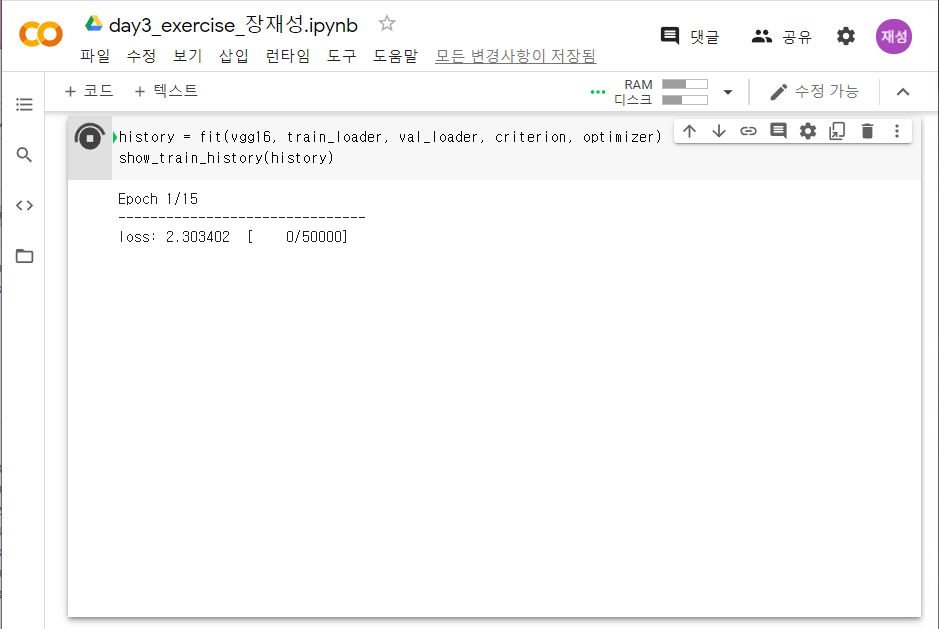

CPU로 진행했는데 여기서 거의 40분동안 1 epoch을 넘어가지를 못했다. 따라서 15 epochs를 돌리는데 하루종일 걸릴 수도 있다고 판단되서 중지하고 이후의 결과는 정답지를 통해 마저 확인하기로 했다.

In [ ]:
torch.save(vgg16, 'vgg16.pt') # 전체 모델 저장

In [ ]:
vgg16_loded = torch.load('vgg16.pt')
vgg16_loded

## 회고

아직 torch가 익숙치 않다. 앞으로 공부해야 할 것이 많아보인다. learning schedule을 설정하는 것은 여러모로 상당히 유용하다고 생각된다. 다양한 방법들이 존재하던데 어떤 차이가 있는지 궁금하다.